<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/An%C3%A1lise_GP_dl_novo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos reconstruir $H(z)$ a partir de dados randômicos de $\mu(z)$. Para isso, usaremos a fórmula abaixo:

$H(z) = \frac{c (1+z)^2}{(1+z) d_L'(z) - d_L(z)}$

Em que $d_L$ = $D_L/c$. Fixando um ruído, iremos aplicá-lo 4 vezes, pois a cada aplicação do ruído temos um novo conjunto de dados. Iremos também variar dz (0.05, 0.1 e 0.15). Deixei o erro fixo em 1%.

Vamos fazer um caso para cada dz.

In [1]:
# Bibliotecas:

import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

In [3]:
import pyccl as ccl

In [ ]:
!pip install git+https://github.com/JCGoran/GaPP@feature/python3#GaPP
from gapp import gp
from numpy import loadtxt, savetxt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

Primeiro caso: dz = 0.05.

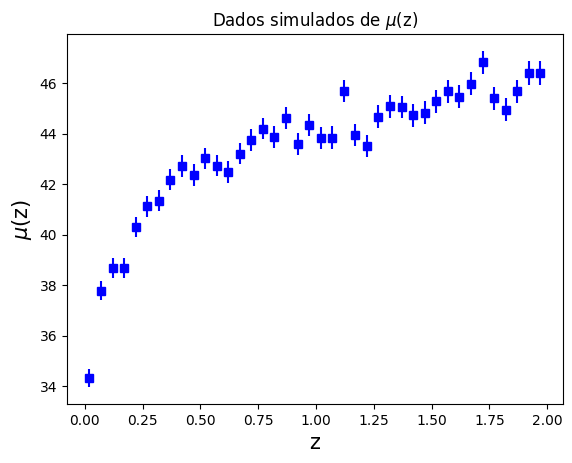

In [7]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.05)

a = 1. / (1. + z)

mu = ccl.distance_modulus(cosmo, a)

emuz = 0.01 * mu

mu = np.random.normal(mu, 0.5)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('$\mu$(z)', fontsize=15)
plt.title('Dados simulados de $\mu$(z)')
plt.errorbar(z, mu, emuz, fmt='s', color='blue')
plt.show()


# salvando os dados

Nmu = z, mu, emuz
#np.savetxt('muz_mocks_novo.dat', np.transpose(Nmu), delimiter='\t')

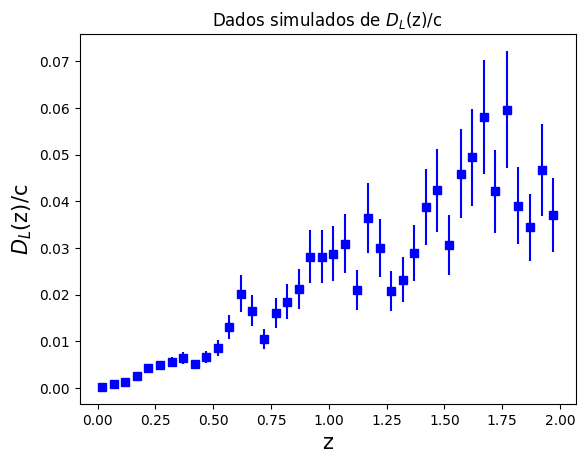

In [8]:
# constante
c = 3*10**5
h0 = 70

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/muz_mocks_novo.dat', delimiter='\t')

z_gapp = data[:, 0]

mu_gapp = data[:, 1]

sig_mu = data[:, 2]


# convertendo para a distância de luminosidade
Dl= np.power(10, ((mu_gapp-25)/5))


# erro da distância de luminosidade
Dlerr = np.sqrt( ( ( (1./5.) * np.log(10.) * Dl) ** 2) * (sig_mu ** 2) )


# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('$D_L$(z)/c', fontsize=15)
plt.title('Dados simulados de $D_L$(z)/c')
plt.errorbar(z, Dl/c, Dlerr/c, fmt='s', color='blue')
plt.show()

Ndl = z, Dl/c, Dlerr/c
#np.savetxt('dlz_mocks_novo.dat', np.transpose(Ndl), delimiter='\t')


Optimized hyperparameters:
theta = [0.02660926 1.46908808]


<ipython-input-10-79d077c78508>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


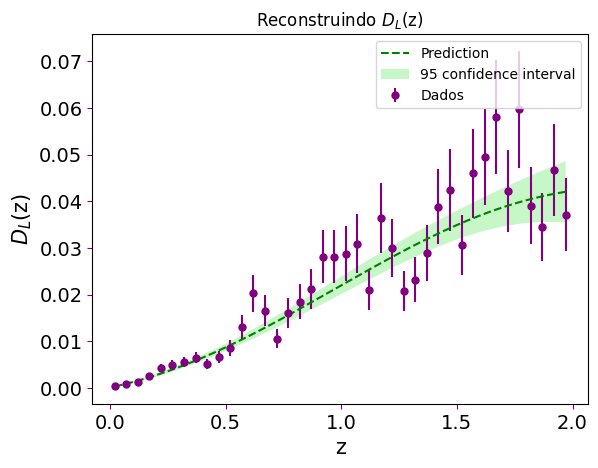

In [10]:
# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/dlz_mocks_novo.dat', delimiter='\t')

z_gapp = data[:, 0]

mu_gapp = data[:, 1]

sig_mu = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = mu_gapp
e = sig_mu

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'95 confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('$D_L$(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo $D_L$(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dlz_recon_mock_novo.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [0.02660926 1.46908808]


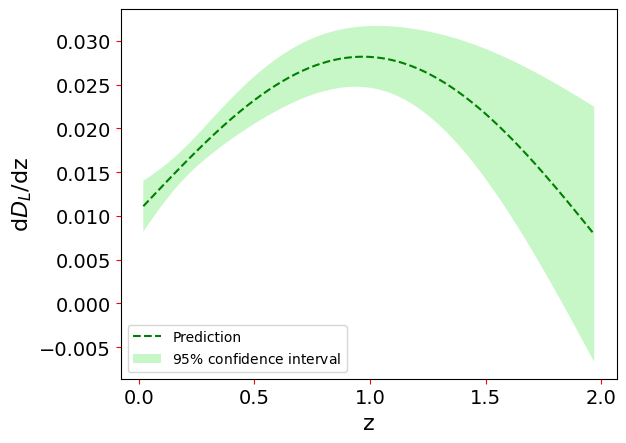

In [11]:
# primeira derivada

from gapp import dgp

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/dlz_mocks_novo.dat', delimiter='\t')

z_gapp = data[:, 0]

mu_gapp = data[:, 1]

sig_mu = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = mu_gapp
e = sig_mu

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('d$D_L$/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('ddlz_recon_mock_novo.dat', np.transpose(H), delimiter='\t')

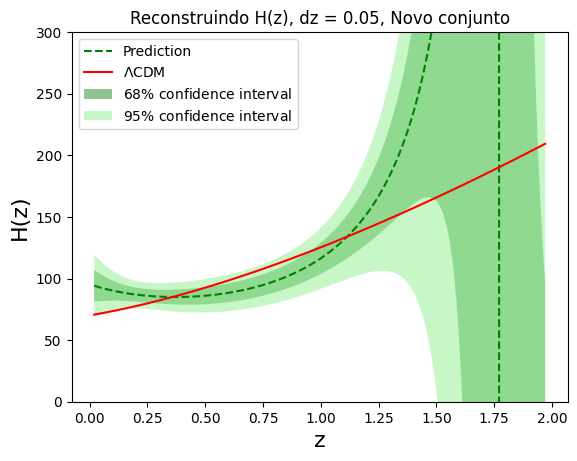

In [12]:
# baixando e nomeando dados reconstruídos de DL
dlz = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/dlz_recon_mock_novo.dat', delimiter='\t')

z_dlz = dlz[:, 0]
dl_dlz = dlz[:, 1]   #dl

edlz = dlz[:, 2]   # erro de dl

# baixando e nomeando dados reconstruídos da derivada de DL
ddlz = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/ddlz_recon_mock_novo.dat', delimiter='\t')

#z_ddl = ddlz[:, 0]

ddl = ddlz[:, 1]  # derivada de dl

eddl = ddlz[:, 2]   # erro da derivada de dl

h = ((1+z_dlz)**2) / ((1+z_dlz)*ddl - dl_dlz)
h_1 = (1+z_dlz)**3
h_2 = ((1+z_dlz)*ddl - dl_dlz)**2
herr = np.sqrt( ((h_1/h_2)*eddl)**2 + (( ((1+z_dlz)**2)/h_2 )*edlz)**2 )


# modelo lcdm
h_lcdm = h0*ccl.background.h_over_h0(cosmo, a)
#h_lcdm2 = h0*(np.sqrt(Om0*((1+z)**3) + O_L0 ))


# plote
fig, ax = plt.subplots()
plt.ylim(0,300)
plt.plot(z_dlz, h, color='green', label='Prediction', linestyle="--")
plt.plot(z, h_lcdm, color='red', label='$\Lambda$CDM')
#plt.plot(z, h_lcdm2, color='purple', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_dlz, z_dlz[::-1]]),
         np.concatenate([h - 1.0000 * herr,
                        (h + 1.0000 * herr)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dlz, z_dlz[::-1]]),
         np.concatenate([h - 1.9600 * herr,
                        (h + 1.9600 * herr)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.legend(loc='best')
plt.xlabel('z', fontsize=16)
plt.ylabel('H(z)', fontsize=16)
plt.title('Reconstruindo H(z), dz = 0.05, Novo conjunto')
plt.show()

Segundo caso: dz = 0.10.

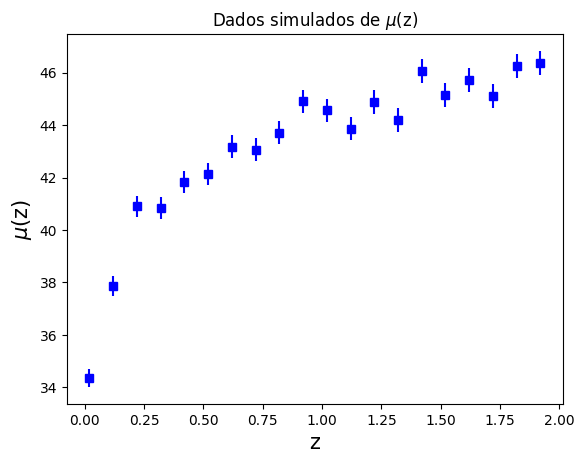

In [13]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.10)

a = 1. / (1. + z)

mu = ccl.distance_modulus(cosmo, a)

emuz = 0.01 * mu

mu = np.random.normal(mu, 0.5)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('$\mu$(z)', fontsize=15)
plt.title('Dados simulados de $\mu$(z)')
plt.errorbar(z, mu, emuz, fmt='s', color='blue')
plt.show()


# salvando os dados

Nmu = z, mu, emuz
#np.savetxt('muz_mocks_novo2.dat', np.transpose(Nmu), delimiter='\t')

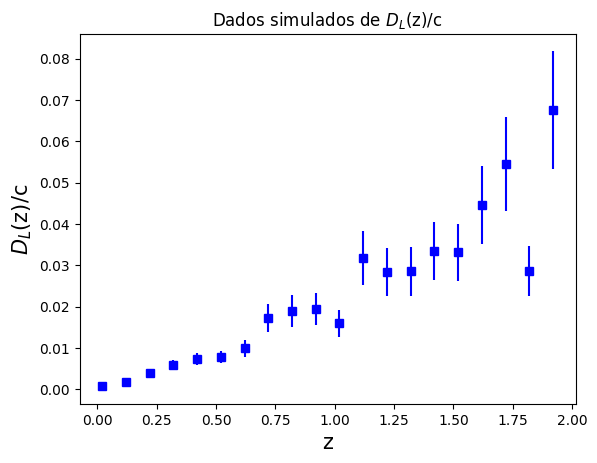

In [14]:
# constante
c = 3*10**5
h0 = 70

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/muz_mocks_novo2.dat', delimiter='\t')

z_gapp = data[:, 0]

mu_gapp = data[:, 1]

sig_mu = data[:, 2]


# convertendo para a distância de luminosidade
Dl= np.power(10, ((mu_gapp-25)/5))


# erro da distância de luminosidade
Dlerr = np.sqrt( ( ( (1./5.) * np.log(10.) * Dl) ** 2) * (sig_mu ** 2) )


# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('$D_L$(z)/c', fontsize=15)
plt.title('Dados simulados de $D_L$(z)/c')
plt.errorbar(z, Dl/c, Dlerr/c, fmt='s', color='blue')
plt.show()

Ndl = z, Dl/c, Dlerr/c
#np.savetxt('dlz_mocks_novo2.dat', np.transpose(Ndl), delimiter='\t')


Optimized hyperparameters:
theta = [0.02660926 1.46908808]


<ipython-input-15-6c9f76473047>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


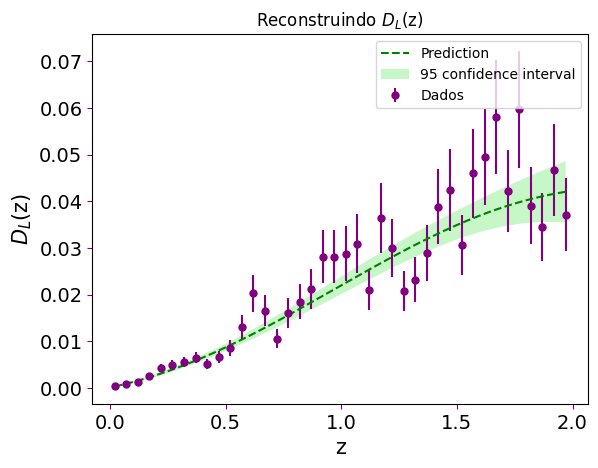

In [15]:
# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/dlz_mocks_novo.dat', delimiter='\t')

z_gapp = data[:, 0]

mu_gapp = data[:, 1]

sig_mu = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = mu_gapp
e = sig_mu

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'95 confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('$D_L$(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo $D_L$(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dlz_recon_mock_novo2.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [0.02660926 1.46908808]


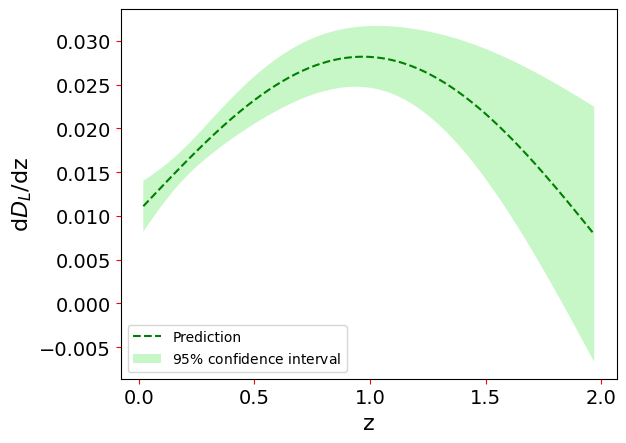

In [16]:
# primeira derivada

from gapp import dgp

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/dlz_mocks_novo.dat', delimiter='\t')

z_gapp = data[:, 0]

mu_gapp = data[:, 1]

sig_mu = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = mu_gapp
e = sig_mu

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('d$D_L$/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('ddlz_recon_mock_novo2.dat', np.transpose(H), delimiter='\t')

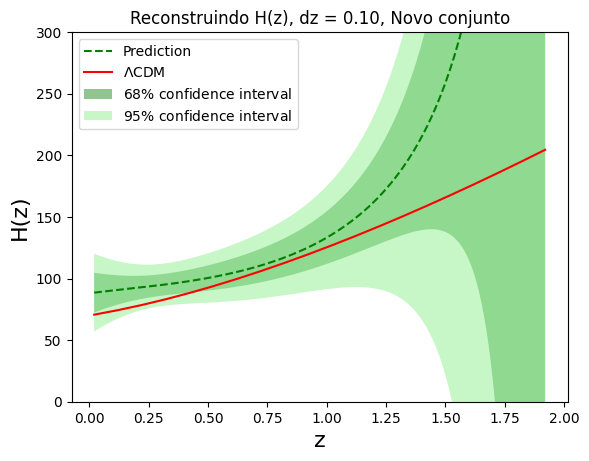

In [17]:
# baixando e nomeando dados reconstruídos de DL
dlz2 = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/dlz_recon_mock_novo2.dat', delimiter='\t')

z_dlz2 = dlz2[:, 0]
dl_dlz2 = dlz2[:, 1]   #dl

edlz2 = dlz2[:, 2]   # erro de dl

# baixando e nomeando dados reconstruídos da derivada de DL
ddlz2 = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/ddlz_recon_mock_novo2.dat', delimiter='\t')

#z_ddl = ddlz[:, 0]

ddl2 = ddlz2[:, 1]  # derivada de dl

eddl2 = ddlz2[:, 2]   # erro da derivada de dl

h2 = ((1+z_dlz2)**2) / ((1+z_dlz2)*ddl2 - dl_dlz2)
h_1_2 = (1+z_dlz2)**3
h_2_2 = ((1+z_dlz2)*ddl2 - dl_dlz2)**2
herr2 = np.sqrt( ((h_1_2/h_2_2)*eddl2)**2 + (( ((1+z_dlz2)**2)/h_2_2 )*edlz2)**2 )


# modelo lcdm
h_lcdm = h0*ccl.background.h_over_h0(cosmo, a)
#h_lcdm2 = h0*(np.sqrt(Om0*((1+z)**3) + O_L0 ))


# plote
fig, ax = plt.subplots()
plt.ylim(0,300)
plt.plot(z_dlz2, h2, color='green', label='Prediction', linestyle="--")
plt.plot(z, h_lcdm, color='red', label='$\Lambda$CDM')
#plt.plot(z, h_lcdm2, color='purple', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_dlz2, z_dlz2[::-1]]),
         np.concatenate([h2 - 1.0000 * herr2,
                        (h2 + 1.0000 * herr2)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dlz2, z_dlz2[::-1]]),
         np.concatenate([h2 - 1.9600 * herr2,
                        (h2 + 1.9600 * herr2)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.legend(loc='best')
plt.xlabel('z', fontsize=16)
plt.ylabel('H(z)', fontsize=16)
plt.title('Reconstruindo H(z), dz = 0.10, Novo conjunto')
plt.show()

Terceiro caso: dz = 0.15.

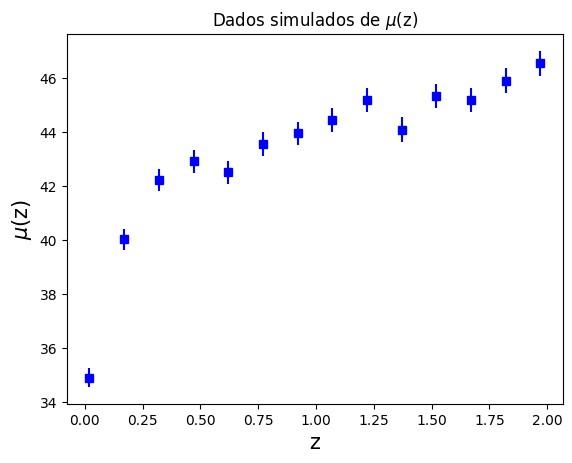

In [18]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.15)

a = 1. / (1. + z)

mu = ccl.distance_modulus(cosmo, a)

emuz = 0.01 * mu

mu = np.random.normal(mu, 0.5)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('$\mu$(z)', fontsize=15)
plt.title('Dados simulados de $\mu$(z)')
plt.errorbar(z, mu, emuz, fmt='s', color='blue')
plt.show()


# salvando os dados

Nmu = z, mu, emuz
#np.savetxt('muz_mocks_novo3.dat', np.transpose(Nmu), delimiter='\t')

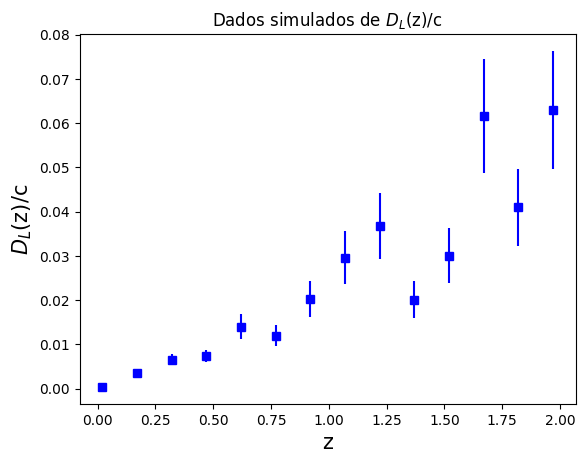

In [19]:
# constante
c = 3*10**5
h0 = 70

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/muz_mocks_novo3.dat', delimiter='\t')

z_gapp = data[:, 0]

mu_gapp = data[:, 1]

sig_mu = data[:, 2]


# convertendo para a distância de luminosidade
Dl= np.power(10, ((mu_gapp-25)/5))


# erro da distância de luminosidade
Dlerr = np.sqrt( ( ( (1./5.) * np.log(10.) * Dl) ** 2) * (sig_mu ** 2) )


# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('$D_L$(z)/c', fontsize=15)
plt.title('Dados simulados de $D_L$(z)/c')
plt.errorbar(z, Dl/c, Dlerr/c, fmt='s', color='blue')
plt.show()

Ndl = z, Dl/c, Dlerr/c
#np.savetxt('dlz_mocks_novo3.dat', np.transpose(Ndl), delimiter='\t')


Optimized hyperparameters:
theta = [0.04998427 3.33120277]


<ipython-input-20-dd0a390108a2>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


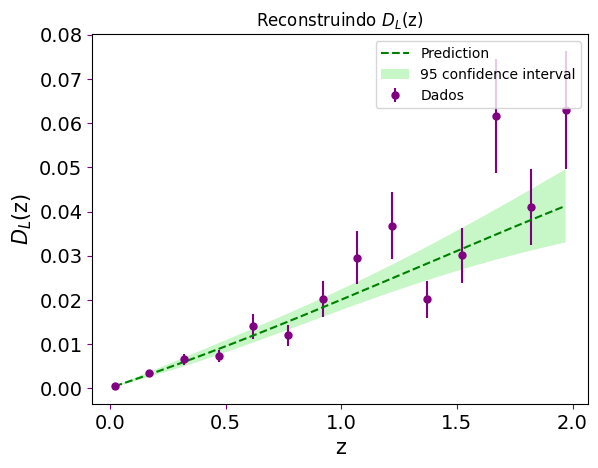

In [20]:
# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/dlz_mocks_novo3.dat', delimiter='\t')

z_gapp = data[:, 0]

mu_gapp = data[:, 1]

sig_mu = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = mu_gapp
e = sig_mu

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'95 confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('$D_L$(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo $D_L$(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dlz_recon_mock_novo3.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [0.04998427 3.33120277]


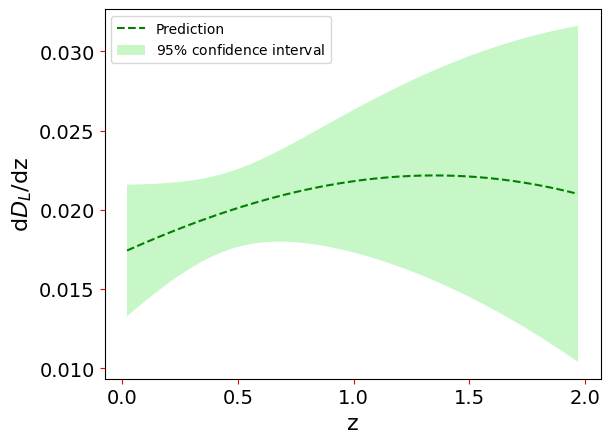

In [21]:
# primeira derivada

from gapp import dgp

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/dlz_mocks_novo3.dat', delimiter='\t')

z_gapp = data[:, 0]

mu_gapp = data[:, 1]

sig_mu = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = mu_gapp
e = sig_mu

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('d$D_L$/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('ddlz_recon_mock_novo3.dat', np.transpose(H), delimiter='\t')

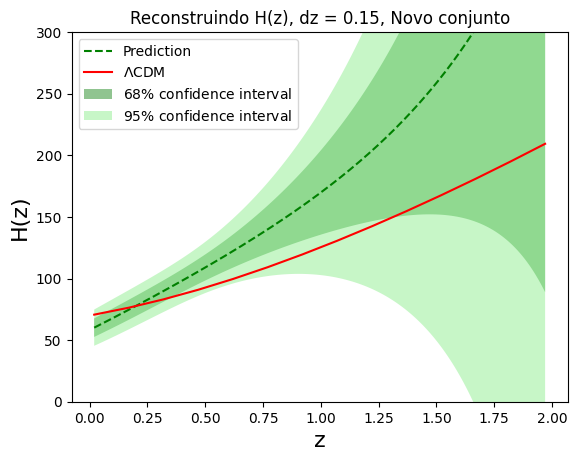

In [22]:
# baixando e nomeando dados reconstruídos de DL
dlz = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/dlz_recon_mock_novo3.dat', delimiter='\t')

z_dlz = dlz[:, 0]
dl_dlz = dlz[:, 1]   #dl

edlz = dlz[:, 2]   # erro de dl

# baixando e nomeando dados reconstruídos da derivada de DL
ddlz = np.genfromtxt('/content/drive/MyDrive/Dados/Mock GP/Reconstrução H dl c/ddlz_recon_mock_novo3.dat', delimiter='\t')

#z_ddl = ddlz[:, 0]

ddl = ddlz[:, 1]  # derivada de dl

eddl = ddlz[:, 2]   # erro da derivada de dl

h = ((1+z_dlz)**2) / ((1+z_dlz)*ddl - dl_dlz)
h_1 = (1+z_dlz)**3
h_2 = ((1+z_dlz)*ddl - dl_dlz)**2
herr = np.sqrt( ((h_1/h_2)*eddl)**2 + (( ((1+z_dlz)**2)/h_2 )*edlz)**2 )


# modelo lcdm
h_lcdm = h0*ccl.background.h_over_h0(cosmo, a)
#h_lcdm2 = h0*(np.sqrt(Om0*((1+z)**3) + O_L0 ))


# plote
fig, ax = plt.subplots()
plt.ylim(0,300)
plt.plot(z_dlz, h, color='green', label='Prediction', linestyle="--")
plt.plot(z, h_lcdm, color='red', label='$\Lambda$CDM')
#plt.plot(z, h_lcdm2, color='purple', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_dlz, z_dlz[::-1]]),
         np.concatenate([h - 1.0000 * herr,
                        (h + 1.0000 * herr)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dlz, z_dlz[::-1]]),
         np.concatenate([h - 1.9600 * herr,
                        (h + 1.9600 * herr)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.legend(loc='best')
plt.xlabel('z', fontsize=16)
plt.ylabel('H(z)', fontsize=16)
plt.title('Reconstruindo H(z), dz = 0.15, Novo conjunto')
plt.show()